**Часть 1**

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
sns.set(style='darkgrid',font_scale=1.4)

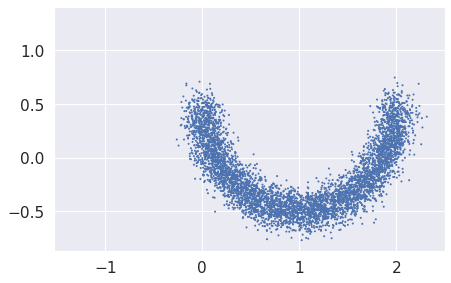

In [ ]:
X,y=make_moons(n_samples=10000,random_state=42,noise=0.1)
plt.figure(figsize=(7,4.5))
plt.scatter(X[:,0],X[:,1],y)
plt.show()

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42)

X_train_t=torch.from_numpy(X_train)
X_train_t=X_train_t.to(torch.float32)
X_test_t=torch.from_numpy(X_test)
X_test_t=X_test_t.to(torch.float32)
y_train_t=torch.from_numpy(y_train)
y_train_t=y_train_t.to(torch.float32)
y_test_t=torch.from_numpy(y_test)
y_test_t=y_test_t.to(torch.float32)

train_ds=TensorDataset(X_train_t,y_train_t)
test_ds=TensorDataset(X_test_t,y_test_t)
train_dl=DataLoader(train_ds,batch_size=128,drop_last=True)
test_dl=DataLoader(test_ds,batch_size=128,drop_last=True)

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, in_features, out_features,bias:bool=True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features,out_features))
        self.bias=bias
        if bias:
          self.bias_term=nn.Parameter(torch.randn(out_features,requires_grad=True))
      
    def forward(self,x):
      x=x@self.weights
      if self.bias:
        x+=self.bias_term
      return x

l_reg=LinearRegression(2,1)
loss_func=nn.BCEWithLogitsLoss()
optimazer=torch.optim.SGD(l_reg.parameters(), lr=0.05)

In [ ]:
#Количество обучаемых параметров (Вопрос 1)

param=sum(i.numel() for i in l_reg.parameters() if i.requires_grad)
print(param)

3


In [ ]:
tol=1e-3
losses=[]
prev_weights=torch.zeros_like(l_reg.weights)
stop_it=False
epoch=100

for epoche in range(epoch):
  for it,(X_batch,y_batch) in enumerate(train_dl):
    X_batch.requires_grad=True
    optimazer.zero_grad()
    output=l_reg.forward(X_batch)
    loss=loss_func(output.squeeze(),y_batch)
    loss.backward()
    optimazer.step()
    probabilities=torch.sigmoid(output)
    preds=(probabilities>0.5).type(torch.long)
    batch_acc=(preds==y_batch).sum()/y_batch.size(0)

    if (it + epoch * len(train_dl)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dl)}\nBatch accuracy: {batch_acc}")
    current_weights = l_reg.weights.detach().clone()
    if (prev_weights - current_weights).abs().max() < tol:
        print(f"\nIteration: {it + epoch * len(train_dl)}.Convergence. Stopping iterations.")
        stop_it = True
        break
    prev_weights = current_weights
  if stop_it:
      break
      
#Количество итераций для сходимости (Вопрос 2)

Iteration: 5800
Batch accuracy: 64.03125

Iteration: 5847.Convergence. Stopping iterations.


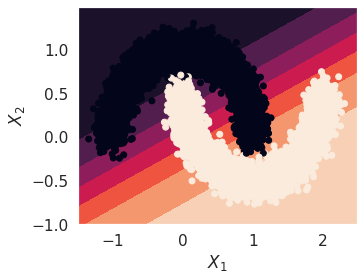

In [ ]:
xx, yy=np.mgrid[-1.5:2.5:0.01,-1:1.5:0.01]
grid=np.c_[xx.ravel(),yy.ravel()]
batch=torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
  probs = torch.sigmoid(l_reg.forward(batch).reshape(xx.shape))
  probs=probs.numpy().reshape(xx.shape)

fig,ax=plt.subplots(figsize=(5,4))
cont=ax.contourf(xx,yy,probs)
ax.scatter(X[100:,0], X[100:, 1], c=y[100:])
ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

In [ ]:
@torch.no_grad()
def predict(dl,model):
  model.eval()
  predictions=np.array([])
  for X_batch,_ in dl:
    preds=torch.sigmoid(model(X_batch))
    for i in range(len(preds)):
      if preds[i]>=0.5:
        predictions=np.hstack([predictions,1])
      else:
        predictions=np.hstack([predictions,0])
  return predictions.flatten()

prd=predict(test_dl,l_reg)
y_test=y_test[0:2432]
acc=accuracy_score(prd,y_test)
print(acc)

#3 Вопрос

0.8671875


**87%**

**Часть2**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs
from functools import wraps

train_ds=torchvision.datasets.MNIST(
    root='./data'
    ,train=True
    ,download=True
    ,transform=tfs.Compose([
      tfs.ToTensor(),
      tfs.Normalize((0.5),(0.5))
    ])
)

test_ds=torchvision.datasets.MNIST(
    root='./data'
    ,train=False
    ,download=True
    ,transform=tfs.Compose([
      tfs.ToTensor(),
      tfs.Normalize((0.5),(0.5))
    ])
)

train_dl=torch.utils.data.DataLoader(train_ds,batch_size=128,drop_last=True)
test_dl=torch.utils.data.DataLoader(test_ds,batch_size=128,drop_last=True)

In [ ]:
device=torch.device('cpu')
if torch.cuda.is_available():
  device=torch.device('cuda')

class NeurealNetwork(nn.Module):
  def __init__(self,nX,nH1,nH2,nY):
    super().__init__()
    self.fc1=nn.Linear(nX,nH1)
    self.fc2=nn.Linear(nH1,nH2)
    self.fc3=nn.Linear(nH2,nY)

  def reset_param(self):
    torch.nn.init.xavier_uniform_(self.fc1.weight)
    torch.nn.init.xavier_uniform_(self.fc2.weight)
    torch.nn.init.xavier_uniform_(self.fc3.weight)

  def batch(self,x):
    self.x=x

  def forward(func):
    @wraps(func)
    def wrapper(self,*args):
      res=func(self,*args)
      return res
    return wrapper

  @forward
  def ELU(self):
    x=nn.Flatten()(self.x)
    x=self.fc1(x)
    x=nn.ELU()(x)
    x=self.fc2(x)
    x=nn.ELU()(x)
    x=self.fc3(x)
    x=nn.ELU()(x)
    return x

  @forward
  def ReLU(self):
    x=nn.Flatten()(self.x)
    x=self.fc1(x)
    x=nn.ReLU()(x)
    x=self.fc2(x)
    x=nn.ReLU()(x)
    x=self.fc3(x)
    x=nn.ReLU()(x)
    return x

  @forward
  def LeakyReLU(self):
    x=nn.Flatten()(self.x)
    x=self.fc1(x)
    x=nn.LeakyReLU()(x)
    x=self.fc2(x)
    x=nn.LeakyReLU()(x)
    x=self.fc3(x)
    x=nn.LeakyReLU()(x)
    return x

model=NeurealNetwork(784,128,128,10)
loss_func=nn.CrossEntropyLoss()
optimazer=torch.optim.Adam(model.parameters())

In [ ]:
epochs=30
load={'train': train_dl, 'test': test_dl}
accuracy={'trainELU':[],'testELU':[],'trainReLU':[],'testReLU':[],'trainLeakyReLU':[],'testLeakyReLU':[]}

for epoch in range(epochs):
  epoch_correct=0
  epoch_all=0
  for key,dataloader in load.items():
    for X_batch,y_batch in dataloader:
      if key=='train':
        model.train()
        optimazer.zero_grad()
        if epoch<10:
          model.batch(X_batch)
          outp=model.ELU()
          title='ELU'
        if epoch>=10 and epoch<20:
          if epoch==10:
            model.reset_param()
          model.batch(X_batch)
          outp=model.ReLU()
          title='ReLU'
        if epoch>=20:
          if epoch==20:
            model.reset_param()
          model.batch(X_batch)
          outp=model.LeakyReLU()
          title='LeakyReLU'
      else:
        model.eval()
        with torch.no_grad():
          if epoch<10:
            model.batch(X_batch)
            outp=model.ELU()
          elif epoch>=10 and epoch<20:
            model.batch(X_batch)
            outp=model.ReLU()
          else:
            model.batch(X_batch)
            outp=model.LeakyReLU()
      preds=outp.argmax(-1)
      correct=(abs(preds-y_batch)==0).sum()
      all=len(y_batch)
      epoch_correct+=correct.item()
      epoch_all+=all
      if key=='train':
        loss=loss_func(outp,y_batch)
        loss.backward()
        optimazer.step()
    if key == 'train':
        print(f"Epoch: {epoch+1}")
    print(f"Loader: {key}. Accuracy {title}: {epoch_correct/epoch_all}")
    if epoch<10:
      if key == 'train':
        accuracy['trainELU'].append(epoch_correct/epoch_all)
      else:
        accuracy['testELU'].append(epoch_correct/epoch_all)
    if epoch>=10 and epoch<20:
      if key == 'train':
        accuracy['trainReLU'].append(epoch_correct/epoch_all)
      else:
        accuracy['testReLU'].append(epoch_correct/epoch_all)
    if epoch>=20:
      if key == 'train':
        accuracy['trainLeakyReLU'].append(epoch_correct/epoch_all)
      else:
        accuracy['testLeakyReLU'].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy ELU: 0.877220219017094
Loader: test. Accuracy ELU: 0.8846296932234432
Epoch: 2
Loader: train. Accuracy ELU: 0.9404547275641025
Loader: test. Accuracy ELU: 0.9421789148351648
Epoch: 3
Loader: train. Accuracy ELU: 0.9586672008547008
Loader: test. Accuracy ELU: 0.958490728021978
Epoch: 4
Loader: train. Accuracy ELU: 0.9675313835470085
Loader: test. Accuracy ELU: 0.9667611034798534
Epoch: 5
Loader: train. Accuracy ELU: 0.9739583333333334
Loader: test. Accuracy ELU: 0.9722556089743589
Epoch: 6
Loader: train. Accuracy ELU: 0.9792501335470085
Loader: test. Accuracy ELU: 0.9774067078754579
Epoch: 7
Loader: train. Accuracy ELU: 0.9824719551282052
Loader: test. Accuracy ELU: 0.9804544413919414
Epoch: 8
Loader: train. Accuracy ELU: 0.9849258814102564
Loader: test. Accuracy ELU: 0.98272951007326
Epoch: 9
Loader: train. Accuracy ELU: 0.9862446581196581
Loader: test. Accuracy ELU: 0.9841031364468864
Epoch: 10
Loader: train. Accuracy ELU: 0.9859274839743589
Loader: te

<function matplotlib.pyplot.show>

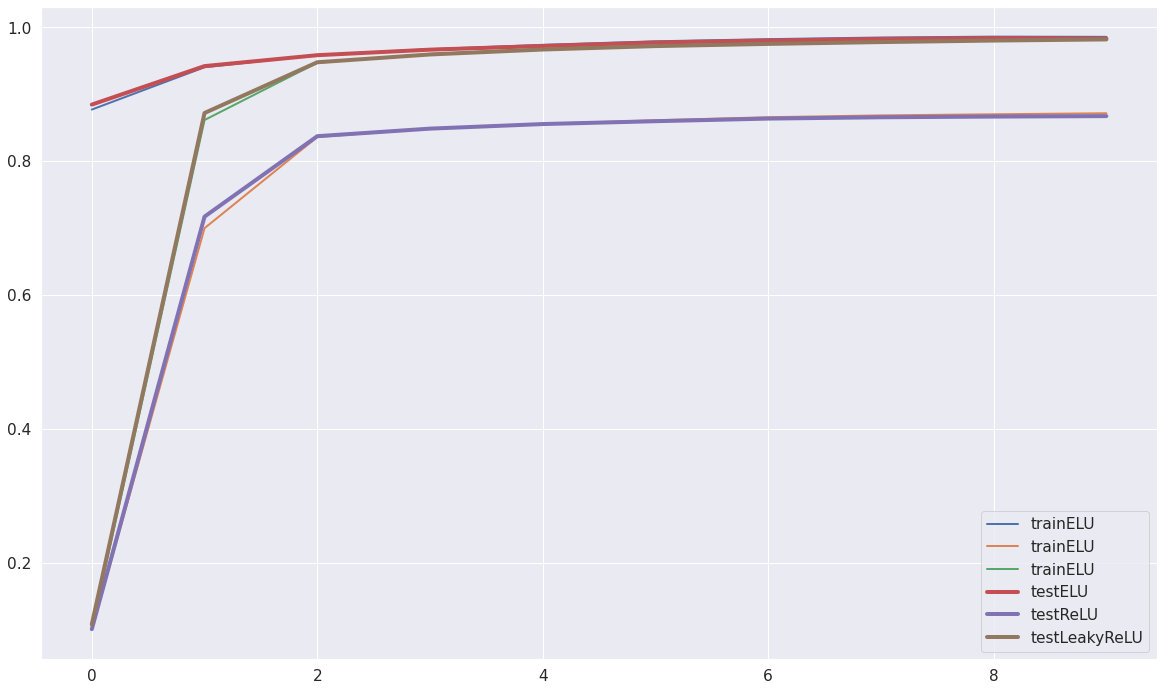

In [ ]:
fig,ax=plt.subplots(figsize=(20,12))
epoch=10
sns.set(style='darkgrid',font_scale=1.4)

plt.plot(range(epoch),accuracy['trainELU'],label='trainELU',linewidth=2)
plt.plot(range(epoch),accuracy['trainReLU'],label='trainELU',linewidth=2)
plt.plot(range(epoch),accuracy['trainLeakyReLU'],label='trainELU',linewidth=2)
plt.plot(range(epoch),accuracy['testELU'],label='testELU',linewidth=4)
plt.plot(range(epoch),accuracy['testReLU'],label='testReLU',linewidth=4)
plt.plot(range(epoch),accuracy['testLeakyReLU'],label='testLeakyReLU',linewidth=4)
plt.legend()
plt.show

**Наибольшая метрика была достигнута при помощи активации ELU и LeakyRelu, обучение проводил в 30 эпох: метод forward задекорировал, и каждые 10 эпох оборачивал методами с разными функциями активации; метод reset_param каждые 10 эпох сбрасывал параметры нейронной сети, чтобы с нуля обучать сеть при другой функции активации. Графики функциональной зависимости количества эпох от типа метрики приведены выше.**

**CNN**

In [ ]:
!wget  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2022-08-13 23:35:50--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2022-08-13 23:35:51--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   163KB/s    in 0.3s    

2022-08-13 23:35:52 (163 KB/s) - ‘sample_photo.jpg’ saved [49337/4

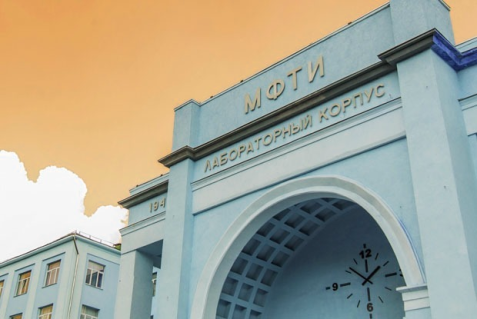

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import torch
from torch import nn
import torch.nn.functional as F

img=cv2.imread('sample_photo.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (477,319), interpolation = cv2.INTER_AREA)
cv2_imshow(img)

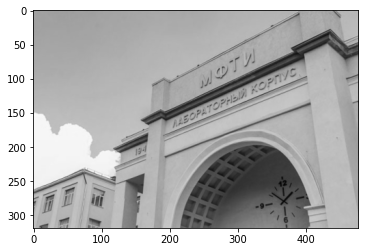

<Figure size 1728x1080 with 0 Axes>

In [ ]:
img_t=torch.from_numpy(img).type(torch.float32).unsqueeze(0)
kernel=torch.tensor([
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
]).reshape(1,1,3,3).type(torch.float32)
kernel=kernel.repeat(3,3,1,1)
img_t=img_t.permute(0,3,1,2)
img_t = nn.ReflectionPad2d(1)(img_t)  
result = F.conv2d(img_t, kernel)[0]

result=result.permute(1,2,0).numpy() / 256 / 3
plt.imshow(result)
plt.figure(figsize=(24,15))
plt.show()

**1Е**
**2А**
**3Г**
**4В**
**5Б**
**6Д**

**LeNet**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs

train_ds=torchvision.datasets.MNIST(
    root='./data'
    ,train=True
    ,download=True
    ,transform=tfs.Compose([
      tfs.ToTensor(),
      tfs.Normalize((0.5),(0.5))
    ])
)

test_ds=torchvision.datasets.MNIST(
    root='./data'
    ,train=False
    ,download=True
    ,transform=tfs.Compose([
      tfs.ToTensor(),
      tfs.Normalize((0.5),(0.5))
    ])
)

train_dl=torch.utils.data.DataLoader(train_ds,batch_size=128,drop_last=True)
test_dl=torch.utils.data.DataLoader(test_ds,batch_size=128,drop_last=True)

In [ ]:
device=torch.device('cpu')
if torch.cuda.is_available():
  device=torch.device('cuda')

class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1=nn.Conv2d(1,6,3)
    self.pool1=nn.MaxPool2d(2,2)
    self.conv2=nn.Conv2d(6,16,3)
    self.pool2=nn.MaxPool2d(2,2)
    self.fc1=nn.Linear(400,120)
    self.fc2=nn.Linear(120,84)
    self.fc3=nn.Linear(84,10)

  def forward(self,x):
    x=self.conv1(x)
    x=nn.ReLU()(x)
    x=self.pool1(x)
    x=self.conv2(x)
    x=nn.ReLU()(x)
    x=self.pool2(x)
    x=nn.Flatten()(x)
    x=self.fc1(x)
    x=nn.ReLU()(x)
    x=self.fc2(x)
    x=nn.ReLU()(x)
    x=self.fc3(x)
    x=nn.ReLU()(x)
    return x

model=LeNet().to(device)
loss_func=nn.CrossEntropyLoss()
optimazer=torch.optim.Adam(model.parameters())

In [ ]:
epochs=10
load={'train': train_dl, 'test': test_dl}
accuracy={'train':[],'test':[]}

for epoch in range(epochs):
  epoch_correct=0
  epoch_all=0
  for key,dataloader in load.items():
    for X_batch,y_batch in dataloader:
      if key=='train':
        model.train()
        optimazer.zero_grad()
        outp=model.forward(X_batch)
      else:
        model.eval()
        with torch.no_grad():
          outp=model.forward(X_batch)
      preds=outp.argmax(-1)
      correct=(abs(preds-y_batch)==0).sum()
      all=len(y_batch)
      epoch_correct+=correct.item()
      epoch_all+=all
      if key=='train':
        loss=loss_func(outp,y_batch)
        loss.backward()
        optimazer.step()
    if key == 'train':
        print(f"Epoch: {epoch+1}")
    print(f"Loader: {key}. Accuracy: {epoch_correct/epoch_all}")
    accuracy[key].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.7142094017094017
Loader: test. Accuracy: 0.7230425824175825
Epoch: 2
Loader: train. Accuracy: 0.7833533653846154
Loader: test. Accuracy: 0.7845839056776557
Epoch: 3
Loader: train. Accuracy: 0.7923010149572649
Loader: test. Accuracy: 0.7925251831501832
Epoch: 4
Loader: train. Accuracy: 0.7964576655982906
Loader: test. Accuracy: 0.7963455815018315
Epoch: 5
Loader: train. Accuracy: 0.7988948985042735
Loader: test. Accuracy: 0.7986778846153846
Epoch: 6
Loader: train. Accuracy: 0.8002637553418803
Loader: test. Accuracy: 0.7998511904761905
Epoch: 7
Loader: train. Accuracy: 0.8016326121794872
Loader: test. Accuracy: 0.8010960393772893
Epoch: 8
Loader: train. Accuracy: 0.8030181623931624
Loader: test. Accuracy: 0.8023551968864469
Epoch: 9
Loader: train. Accuracy: 0.8039029113247863
Loader: test. Accuracy: 0.8030849358974359
Epoch: 10
Loader: train. Accuracy: 0.8047709668803419
Loader: test. Accuracy: 0.8038432921245421


**80.47% тренировочное**

**80.38% тестовое**

<function matplotlib.pyplot.show>

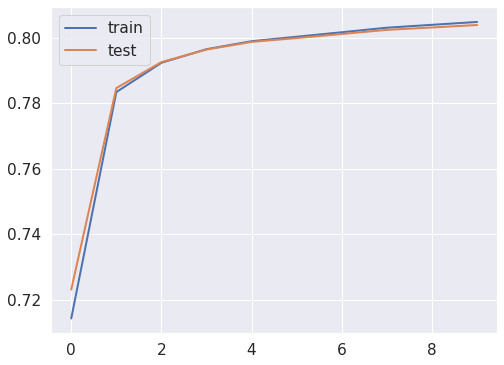

In [ ]:
fig,ax=plt.subplots(figsize=(8,6))
epoch=10
sns.set(style='darkgrid',font_scale=1.4)

plt.plot(range(epoch),accuracy['train'],label='train',linewidth=2)
plt.plot(range(epoch),accuracy['test'],label='test',linewidth=2)
plt.legend()
plt.show